> Template from https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens

## environment setup

`transformer-utils` is a package i wrote!

see the source at https://github.com/nostalgebraist/transformer-utils/

In [1]:
%pip install transformer-utils

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
!nvidia-smi

Tue Nov 18 17:11:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.85                 Driver Version: 555.85         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090      WDDM  |   00000000:01:00.0  On |                  Off |
| 32%   28C    P8             20W /  450W |     607MiB /  24564MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## code setup

In [3]:
import transformers

tokenizer = transformers.AutoTokenizer.from_pretrained("google/gemma-3-1b-it")

C:\Users\yh1242\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import gc
import torch

def cleanup_model(model):
    try:
      if hasattr(model, 'base_model_prefix') and len(model.base_model_prefix) > 0:
        bm = getattr(model, model.base_model_prefix)
        del bm
    except:
      pass
    del model

    gc.collect()
    torch.cuda.empty_cache()

#### Load model (Gemma)

In [5]:
from transformers import AutoTokenizer, BitsAndBytesConfig, Gemma3ForCausalLM
model_id = "google/gemma-3-1b-it"

quantization_config = BitsAndBytesConfig(load_in_8bit=True)

model = Gemma3ForCausalLM.from_pretrained(
    model_id, quantization_config=quantization_config
)

#output the intermediate hidden states
model.config.output_hidden_states = True
model.eval()

Gemma3ForCausalLM(
  (model): Gemma3TextModel(
    (embed_tokens): Gemma3TextScaledWordEmbedding(262144, 1152, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma3DecoderLayer(
        (self_attn): Gemma3Attention(
          (q_proj): Linear8bitLt(in_features=1152, out_features=1024, bias=False)
          (k_proj): Linear8bitLt(in_features=1152, out_features=256, bias=False)
          (v_proj): Linear8bitLt(in_features=1152, out_features=256, bias=False)
          (o_proj): Linear8bitLt(in_features=1024, out_features=1152, bias=False)
          (q_norm): Gemma3RMSNorm((256,), eps=1e-06)
          (k_norm): Gemma3RMSNorm((256,), eps=1e-06)
        )
        (mlp): Gemma3MLP(
          (gate_proj): Linear8bitLt(in_features=1152, out_features=6912, bias=False)
          (up_proj): Linear8bitLt(in_features=1152, out_features=6912, bias=False)
          (down_proj): Linear8bitLt(in_features=6912, out_features=1152, bias=False)
          (act_fn): GELUTanh()
        )
        (

## texts to token

In [6]:
questions_on_empiricism = [
    'Alex can see things with his eyes. When could Alex see with his eyes for the first time?',
    'When there is a sound close by, Alex can hear it. When could Alex hear sounds for the first time?',
    'When seeing a red flower and a blue flower, Alex can tell that they are different colors. Alex can tell colors apart. \
    When could Alex tell colors apart for the first time?',
    'When there is a car approaching, Alex can tell that the car is getting closer. Alex can tell what is near and what is far. \
    When could Alex tell near and far for the first time?',
    'When Alex sees someone hold an object and then drop it, Alex thinks the object will fall. Alex thinks objects will fall if we let go of them.\
     When could Alex think that for the first time?',
    'If Alex sees a toy being hidden in a box, he will think the object is still there even though he can no longer see it.\
     When could Alex think that for the first time?',
    'If Alex sees two cookies, one with 5 chocolate chips in it and one with 20 chocolate chips in it, he can tell which cookie has more chocolate chips without counting. \
     When could Alex tell which has more for the first time?',
    'If Alex sees a turtle that is upside down and struggling to get on its feet, he thinks that he should help the turtle. Alex thinks that helping is the right thing to do. \
    When could Alex think that for the first time?',
    'Alex can read books. When could Alex read for the first time? '
]

In [7]:
import kagglehub
import glob

# FGNET age progression dataset from kaggle
path = kagglehub.dataset_download("aiolapo/fgnet-dataset")

age_paths = {'newborn': glob.glob(f"{path}/**/080A00.JPG", recursive=True)[0], "older_infant": glob.glob(f"{path}/**/080A01.JPG", recursive=True)[0],
            'toddler': glob.glob(f"{path}/**/080A02.JPG", recursive=True)[0], 'preschool_child': glob.glob(f"{path}/**/080A04.JPG", recursive=True)[0],
            'schoolage_child': glob.glob(f"{path}/**/080A07.JPG", recursive=True)[0]}

In [8]:
messages = [
    [
        {
            "role": "system",
             "content": [{"type": "text", "text": "You are a human answering questions for a psychology survey."}]
        },
        {
            "role": "user",
           "content": [
            {"type": "image", "url": age_paths['newborn']},
          {"type": "image", "url": age_paths['toddler']},
          {"type": "image", "url": age_paths['schoolage_child']},
          {"type": "text", "text": f'{questions_on_empiricism[-2]} Pick from image 1, 2, 3. \
           You must reply with either 1, 2, or 3 and specify the age of the child.'},
        ]
        },
    ],
]

inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
).to('cuda').to(torch.bfloat16)



original_input_tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0], 
                                                        skip_special_tokens=False)

input_ids = inputs['input_ids'][:,:10]
print("Input shape: ", inputs["input_ids"].shape)

Attempting to cast a BatchEncoding to type torch.bfloat16. This is not supported.


Input shape:  torch.Size([1, 107])


In [9]:
inputs

{'input_ids': tensor([[     2,    105,   2364,    107,   3048,    659,    496,   3246,  38020,
           4137,    573,    496,  30157,   9375, 236761,    108, 255999, 255999,
         255999,   2859,   8451,  17149,    496,  36100,    600,    563,  40456,
           1679,    532,  22684,    531,    974,    580,   1061,   6172, 236764,
            668,  20547,    600,    668,   1374,   1601,    506,  36100, 236761,
           8451,  20547,    600,   9795,    563,    506,   1447,   3210,    531,
            776, 236761,    141,   4420,   1451,   8451,   1751,    600,    573,
            506,   1171,    990, 236881,  24067,    699,   2471, 236743, 236770,
         236764, 236743, 236778, 236764, 236743, 236800, 236761,    148,   3048,
           1921,  15148,    607,   3477, 236743, 236770, 236764, 236743, 236778,
         236764,    653, 236743, 236800,    532,  20193,    506,   3911,    529,
            506,   1919, 236761,    106,    107,    105,   4368,    107]],
       device='cuda:

In [10]:
original_input_tokens

['<bos>',
 '<start_of_turn>',
 'user',
 '\n',
 'You',
 '▁are',
 '▁a',
 '▁human',
 '▁answering',
 '▁questions',
 '▁for',
 '▁a',
 '▁psychology',
 '▁survey',
 '.',
 '\n\n',
 '<start_of_image>',
 '<start_of_image>',
 '<start_of_image>',
 'If',
 '▁Alex',
 '▁sees',
 '▁a',
 '▁turtle',
 '▁that',
 '▁is',
 '▁upside',
 '▁down',
 '▁and',
 '▁struggling',
 '▁to',
 '▁get',
 '▁on',
 '▁its',
 '▁feet',
 ',',
 '▁he',
 '▁thinks',
 '▁that',
 '▁he',
 '▁should',
 '▁help',
 '▁the',
 '▁turtle',
 '.',
 '▁Alex',
 '▁thinks',
 '▁that',
 '▁helping',
 '▁is',
 '▁the',
 '▁right',
 '▁thing',
 '▁to',
 '▁do',
 '.',
 '▁▁▁▁▁',
 'When',
 '▁could',
 '▁Alex',
 '▁think',
 '▁that',
 '▁for',
 '▁the',
 '▁first',
 '▁time',
 '?',
 '▁Pick',
 '▁from',
 '▁image',
 '▁',
 '1',
 ',',
 '▁',
 '2',
 ',',
 '▁',
 '3',
 '.',
 '▁▁▁▁▁▁▁▁▁▁▁▁',
 'You',
 '▁must',
 '▁reply',
 '▁with',
 '▁either',
 '▁',
 '1',
 ',',
 '▁',
 '2',
 ',',
 '▁or',
 '▁',
 '3',
 '▁and',
 '▁specify',
 '▁the',
 '▁age',
 '▁of',
 '▁the',
 '▁child',
 '.',
 '<end_of_turn>',
 '\n',

In [11]:
# all the intermediate hidden states
with torch.no_grad():
    outputs = model.generate(**inputs, max_new_tokens=64,
                             return_dict_in_generate=True, output_hidden_states=True)

In [12]:
hidden_states = outputs.hidden_states[0]
print("Number of model layers", len(hidden_states))
print("Hidden states for first layer", hidden_states[0].shape) 

Number of model layers 27
Hidden states for first layer torch.Size([1, 107, 1152])


In [13]:
logits_at_second_layer = model.lm_head(hidden_states[2])
print("Logits at second layer shape: ", logits_at_second_layer.shape)

Logits at second layer shape:  torch.Size([1, 107, 262144])


### functions from Logit Lens with Hugging Face Transformers 
> https://alessiodevoto.github.io/LogitLens/

In [14]:
def entropy_from_logits(logits):
    probs = torch.nn.functional.softmax(logits, dim=-1).clamp(1e-8, 1) #avoid nans
    return -torch.sum(probs * torch.log(probs), dim=-1).squeeze()

In [15]:
logitlens = []
entropies = []

for i, hidden_state in enumerate(hidden_states):

    # apply the language model head to the hidden states
    logits = model.lm_head(hidden_state)

    # get the entropy of the logits
    entropy = entropy_from_logits(logits).float().cpu().detach().numpy()

    # decode the logits to get the predicted token ids
    predicted_token_ids = logits.argmax(-1)

    # convert the token ids to tokens
    predicted_tokens = tokenizer.batch_decode(predicted_token_ids[0], skip_special_tokens=True)

    # append the predicted tokens to the list
    logitlens.append(predicted_tokens)
    entropies.append(entropy)

    print(f"Layer {i}: {predicted_tokens}")

Layer 0: ['', '', 'user', '\n', 'You', ' are', ' a', ' human', ' answering', ' questions', ' for', ' a', ' psychology', ' survey', '.', '\n\n', '', '', '', 'If', ' Alex', ' sees', ' a', ' turtle', ' that', ' is', ' upside', ' down', ' and', ' struggling', ' to', ' get', ' on', ' its', ' feet', ',', ' he', ' thinks', ' that', ' he', ' should', ' help', ' the', ' turtle', '.', ' Alex', ' thinks', ' that', ' helping', ' is', ' the', ' right', ' thing', ' to', ' do', '.', '     ', 'When', ' could', ' Alex', ' think', ' that', ' for', ' the', ' first', ' time', '?', ' Pick', ' from', ' image', ' ', '1', ',', ' ', '2', ',', ' ', '3', '.', '            ', 'You', ' must', ' reply', ' with', ' either', ' ', '1', ',', ' ', '2', ',', ' or', ' ', '3', ' and', ' specify', ' the', ' age', ' of', ' the', ' child', '.', '', '\n', '', 'model', '\n']
Layer 1: ['', "'", ' G', '4', ' L', ' P', ' L', ' T', "'", ' T', ' L', ' L', "'", ' and', ' L', '1', 'is', 'n', 'n', ' L', 'oc', ' S', ' L', '’', ' H', ' S

C:\Users\yh1242\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\yh1242\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Text(220.72222222222223, 0.5, 'Model Layers')

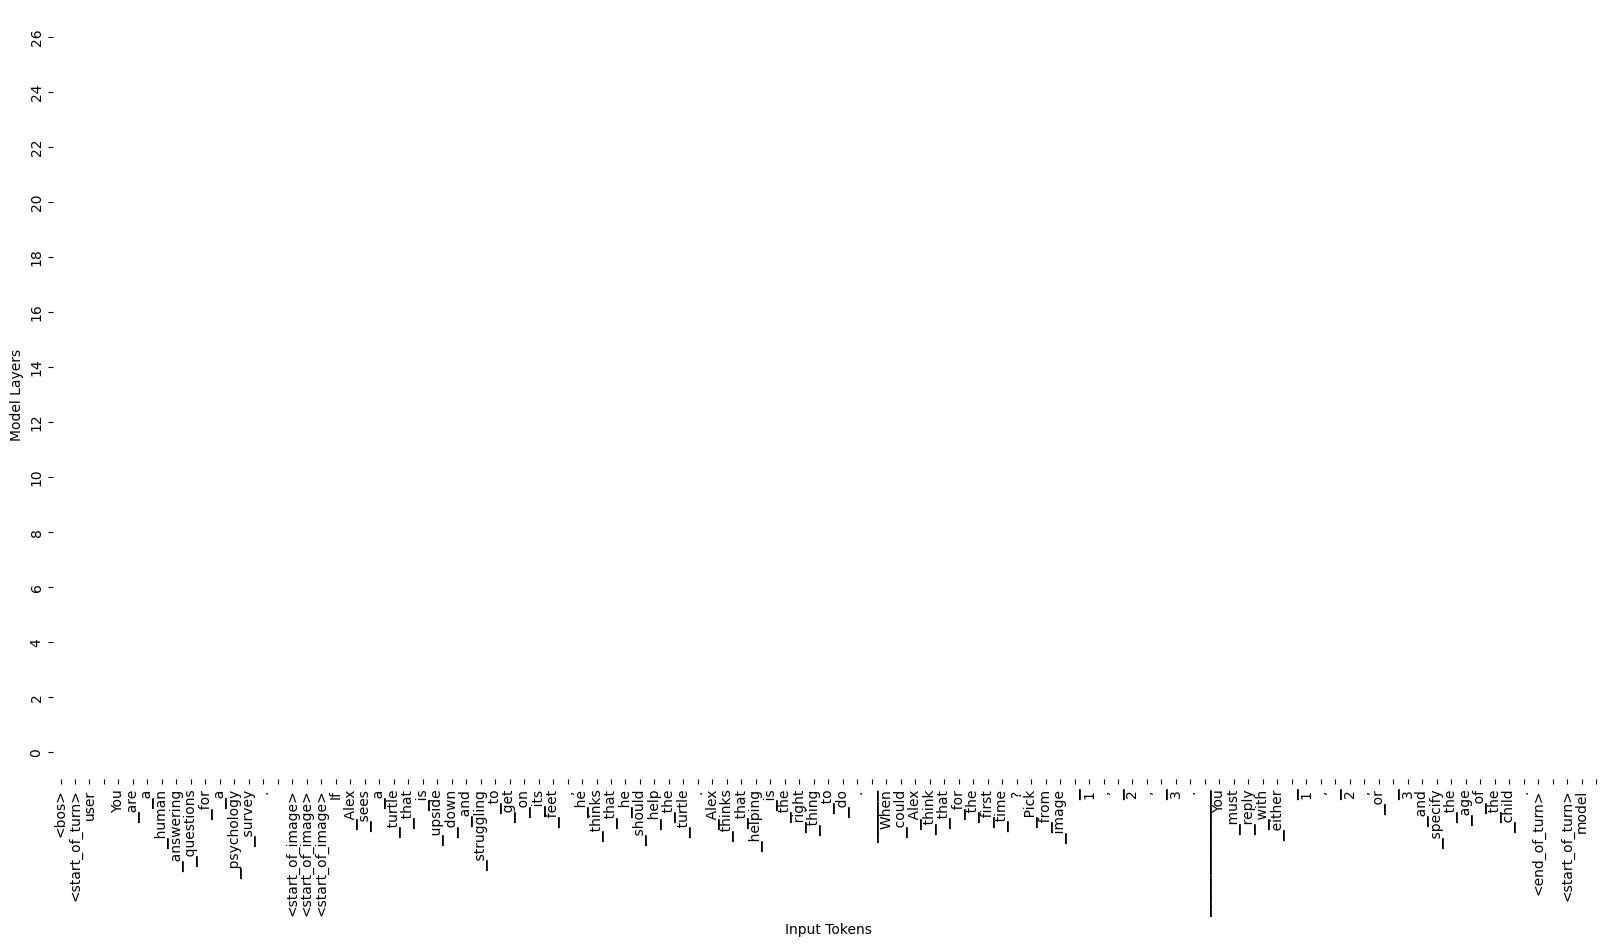

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Create figure and axis
plt.figure(figsize=(20, 10))

# Create heatmap
skip_every_n = 2
ax = sns.heatmap(np.stack(entropies)[::skip_every_n],
                annot=logitlens[::skip_every_n],
                fmt='',
                cmap='YlGnBu',
                xticklabels=original_input_tokens,
                yticklabels=list(range(len(logitlens)))[::skip_every_n],
                cbar=False
                ).invert_yaxis()

plt.xlabel('Input Tokens')
plt.ylabel('Model Layers')

In [17]:
id_1 = tokenizer("1", add_special_tokens=False).input_ids[0]
id_2 = tokenizer("2", add_special_tokens=False).input_ids[0]
id_3 = tokenizer("3", add_special_tokens=False).input_ids[0]

print("IDs:", id_1, id_2, id_3)
print("Tokens:", tokenizer.batch_decode([id_1, id_2, id_3]))

num_layers = len(hidden_states)

probs_over_layers = []   

for i, hidden_state in enumerate(hidden_states):
    logits = model.lm_head(hidden_state)    

    # softmax over vocab to get probabilities
    probs = torch.softmax(logits, dim=-1)    

    p_123 = probs[0, :, [id_1, id_2, id_3]]  

    probs_over_layers.append(p_123.detach().cpu().numpy())

    last_pos = -1
    p_last = p_123[last_pos].tolist()
    print(f"Layer {i}: P('1')={p_last[0]:.4f}, P('2')={p_last[1]:.4f}, P('3')={p_last[2]:.4f}")
    
probs_over_layers = np.stack(probs_over_layers)  


IDs: 236770 236778 236800
Tokens: ['1', '2', '3']
Layer 0: P('1')=0.0000, P('2')=0.0000, P('3')=0.0000
Layer 1: P('1')=0.0276, P('2')=0.0000, P('3')=0.0904
Layer 2: P('1')=0.0261, P('2')=0.0000, P('3')=0.1409
Layer 3: P('1')=0.1091, P('2')=0.0000, P('3')=0.3157
Layer 4: P('1')=0.0000, P('2')=0.0000, P('3')=0.0000
Layer 5: P('1')=0.0000, P('2')=0.0000, P('3')=0.0000
Layer 6: P('1')=0.0000, P('2')=0.0000, P('3')=0.0000
Layer 7: P('1')=0.0000, P('2')=0.0000, P('3')=0.0000
Layer 8: P('1')=0.0000, P('2')=0.0000, P('3')=0.0000
Layer 9: P('1')=0.0000, P('2')=0.0000, P('3')=0.0000
Layer 10: P('1')=0.0000, P('2')=0.0000, P('3')=0.0000
Layer 11: P('1')=0.0000, P('2')=0.0000, P('3')=0.0000
Layer 12: P('1')=0.0000, P('2')=0.0000, P('3')=0.0000
Layer 13: P('1')=0.0000, P('2')=0.0000, P('3')=0.0000
Layer 14: P('1')=0.0000, P('2')=0.0000, P('3')=0.0000
Layer 15: P('1')=0.0000, P('2')=0.0000, P('3')=0.0000
Layer 16: P('1')=0.0000, P('2')=0.0000, P('3')=0.0000
Layer 17: P('1')=0.0000, P('2')=0.0000, P(

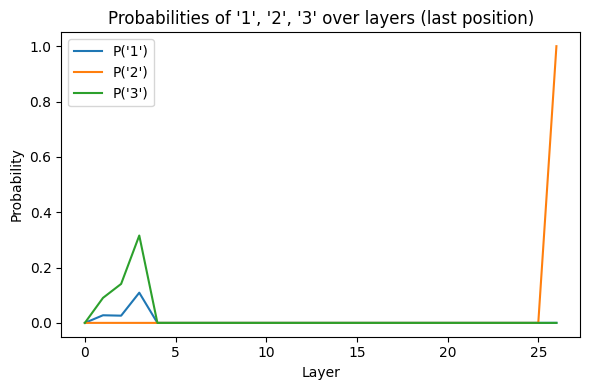

In [18]:
layer_idx = np.arange(num_layers)
pos = -1 

p1 = probs_over_layers[:, pos, 0]
p2 = probs_over_layers[:, pos, 1]
p3 = probs_over_layers[:, pos, 2]

plt.figure(figsize=(6,4))
plt.plot(layer_idx, p1, label="P('1')")
plt.plot(layer_idx, p2, label="P('2')")
plt.plot(layer_idx, p3, label="P('3')")
plt.xlabel("Layer")
plt.ylabel("Probability")
plt.title("Probabilities of '1', '2', '3' over layers (last position)")
plt.legend()
plt.tight_layout()
plt.show()

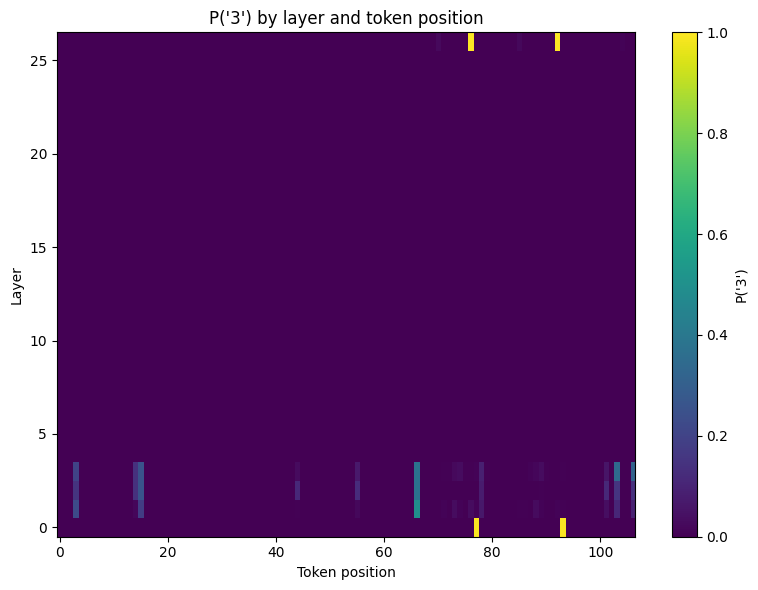

In [19]:
token_idx = 2
p1_all = probs_over_layers[:, :, token_idx] 

plt.figure(figsize=(8,6))
plt.imshow(p1_all, aspect='auto', origin='lower')
plt.colorbar(label=f"P('{token_idx+1}')")
plt.xlabel("Token position")
plt.ylabel("Layer")
plt.title(f"P('{token_idx+1}') by layer and token position")
plt.tight_layout()
plt.show()


In [20]:
cleanup_model(model)